In [105]:
# import libraries
import pandas as pd
import dask.dataframe as dd
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [106]:
# load client and invoice datasets
client_test = pd.read_csv('data/client_test.csv')
client_train = pd.read_csv('data/client_train.csv')

# compress large csv files
def compress_csv(input_file, output_file):
    df = dd.read_csv(input_file, blocksize='16MB', 
                     dtype={'counter_statue': 'object'}) 

    df.to_parquet(output_file.replace('.xz', '.parquet'), compression='snappy')
    
    return df  

invoice_train = compress_csv('data/invoice_train.csv', 'data/invoice_train_compressed.csv.xz')
invoice_test = compress_csv('data/invoice_test.csv', 'data/invoice_test_compressed.csv.xz')

# delete original csv files
os.remove('data/invoice_train.csv')
os.remove('data/invoice_test.csv')

In [80]:
# inspect client training dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [81]:
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


<Axes: title={'center': 'Distribution of Classifications'}, xlabel='prediction'>

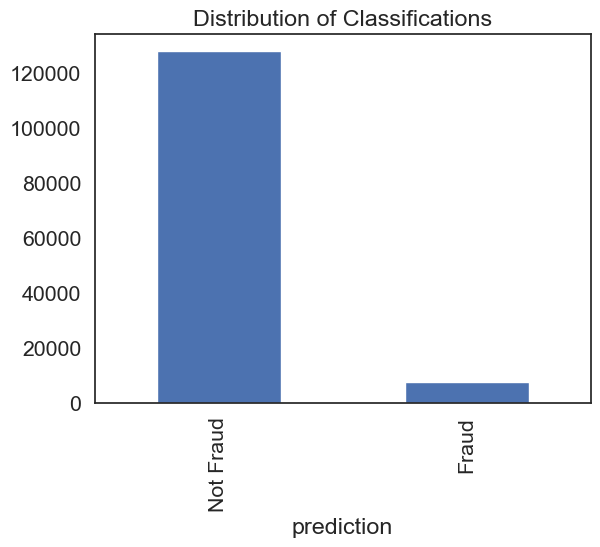

In [82]:
# Create a new column called prediction
client_train['prediction'] = np.where(client_train['target']==1, "Fraud", "Not Fraud")

# Then remove the target column
client_train.drop('target', axis=1, inplace=True)

client_train['prediction'].value_counts().plot(kind = 'bar', title = 'Distribution of Classifications')

Observation: <br>
This bar plot shows the distribution of fraud and non-fraud classifications in the training dataset. The training dataset is imbalanced, with more "Not Fraud" than "Fraud" classifications.

In [90]:
# check the column names to identify the common key for merging
print("\nClient Train Columns:", client_train.columns.tolist())
print("Invoice Train Columns:", invoice_train.columns.tolist())


Client Train Columns: ['disrict', 'client_id', 'client_catg', 'region', 'creation_date', 'target']
Invoice Train Columns: ['client_id', 'invoice_date', 'tarif_type', 'counter_number', 'counter_statue', 'counter_code', 'reading_remarque', 'counter_coefficient', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'old_index', 'new_index', 'months_number', 'counter_type']


In [91]:
# merge client and invoice training dataset
merged_train = client_train.merge(invoice_train.compute(), on='client_id', how='inner')

In [92]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   disrict               int64  
 1   client_id             object 
 2   client_catg           int64  
 3   region                int64  
 4   creation_date         object 
 5   target                float64
 6   invoice_date          object 
 7   tarif_type            int64  
 8   counter_number        int64  
 9   counter_statue        object 
 10  counter_code          int64  
 11  reading_remarque      int64  
 12  counter_coefficient   int64  
 13  consommation_level_1  int64  
 14  consommation_level_2  int64  
 15  consommation_level_3  int64  
 16  consommation_level_4  int64  
 17  old_index             int64  
 18  new_index             int64  
 19  months_number         int64  
 20  counter_type          object 
dtypes: float64(1), int64(15), object(5)
memory usage: 717.3+ MB


In [93]:
merged_train.describe()

,disrict,client_catg,region,target,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,6.348246e+01,1.194381e+01,2.103584e+02,7.887688e-02,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,3.273403e+00,6.022452e+00,1.035828e+02,2.695465e-01,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,6.000000e+01,1.100000e+01,1.010000e+02,0.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.200000e+01,1.100000e+01,1.030000e+02,0.000000e+00,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,6.200000e+01,1.100000e+01,3.010000e+02,0.000000e+00,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,6.300000e+01,1.100000e+01,3.090000e+02,0.000000e+00,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,6.900000e+01,5.100000e+01,3.990000e+02,1.000000e+00,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [94]:
# check for missing data
merged_train.isnull().sum()

disrict                 0
client_id               0
client_catg             0
region                  0
creation_date           0
target                  0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [95]:
# Calculate the number of unique values in each numeric column
unique_values = merged_train.select_dtypes(include='number').nunique()

# Get the columns where there is only one unique value
zero_variance_columns = unique_values[unique_values == 1].index.tolist()

# Print the list of columns with zero variance (constant columns)
print("Columns with only one unique value (zero variance):", zero_variance_columns)

Columns with only one unique value (zero variance): []


Conclusion: <br>
Since numerical columns are actually categorical, they represent discrete categories rather than continuous values. In this scenario, the standard variance calculation may not fully capture their importance, but columns with zero variance still indicate no variability in the data. For categorical columns, it may be more meaningful to look at unique counts rather than variance. This means those columns are constant across all rows and can be removed.

In [96]:
# check for duplicated rows
merged_train[merged_train.duplicated()]

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
951893,60,train_Client_125864,11,101,29/12/1998,0.0,2011-12-12,11,101545,5,...,6,1,0,0,0,0,13680,13680,2,ELEC
1755798,62,train_Client_25894,11,301,16/06/1995,0.0,2010-07-13,40,6986740,5,...,6,1,0,0,0,0,0,0,2,GAZ
2137999,60,train_Client_3636,11,101,21/11/1988,0.0,2012-01-18,40,312650,5,...,6,1,0,0,0,0,623,623,2,GAZ
2163374,60,train_Client_37069,11,101,09/03/1990,0.0,2010-10-11,11,5284,5,...,6,1,0,0,0,0,99429,99429,2,ELEC
2433919,60,train_Client_44407,11,101,15/06/1989,1.0,2008-02-28,11,66921,5,...,6,1,0,0,0,0,0,0,2,ELEC
2805729,60,train_Client_54609,11,101,16/02/1994,0.0,2010-04-06,11,200912,5,...,6,1,0,0,0,0,0,0,2,ELEC
3260191,63,train_Client_66981,51,313,20/11/1996,1.0,2006-07-17,11,132701,5,...,6,1,0,0,0,0,5946,5946,2,ELEC
3260198,63,train_Client_66981,51,313,20/11/1996,1.0,2006-07-17,11,132701,5,...,6,1,0,0,0,0,5946,5946,2,ELEC
3394719,62,train_Client_7066,11,304,12/04/2013,0.0,2014-10-28,40,4463323,5,...,6,1,0,0,0,0,80,80,2,GAZ
3462929,60,train_Client_72519,11,101,03/06/1982,0.0,2013-01-21,11,246464,5,...,6,1,0,0,0,0,2954,2954,2,ELEC


In [97]:
# Drop duplicate rows
merged_train = merged_train.drop_duplicates()

In [98]:
# check for duplicated rows
merged_train[merged_train.duplicated()]

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type


For categorical data, especially if it's encoded as integers, checking for outliers is generally not applicable in the same way it is for numerical data. For integer-encoded categorical data, checking for outliers in the traditional sense (e.g., using z-scores, interquartile ranges) is irrelevant because the values simply represent different categories. They are not continuous or ordinal numbers where "extreme values" could be identified.

However, checking for rare categories or incorrect values in the dataset could be useful.
1. Rare Categories
- Some categories may have very few occurrences. Depending on the context, you might want to handle these categories differently (e.g., combining rare categories, creating an "Other" category).
2. Data Entry Errors
- If the integer encoding was incorrect or there are invalid categories (e.g., an integer that doesn't correspond to a valid category), you might want to investigate and clean these errors.

In [99]:
# Function to identify rare categories based on a threshold
def check_rare_categories(data, column, threshold=0.05):
    # Count the frequency of each category
    value_counts = data[column].value_counts(normalize=True)
    
    # Filter out categories that are rare (below the threshold)
    rare_categories = value_counts[value_counts < threshold]
    
    return rare_categories

# Function to check for unexpected/incorrect values in a column
def check_unexpected_values(data, column, valid_categories):
    # Get the unique values in the column
    unique_values = data[column].unique()
    
    # Find values that are not in the valid categories list
    incorrect_values = [val for val in unique_values if val not in valid_categories]
    
    return incorrect_values

In [100]:
# check for outliers
columns_to_check = [
    'disrict', 'client_catg', 'region', 
    'tarif_type', 'counter_number', 
    'reading_remarque', 'counter_coefficient', 
    'consommation_level_1', 'consommation_level_2',
    'consommation_level_3', 'consommation_level_4',
    'old_index', 'new_index', 'months_number'
]

# Function to find records with outliers
def find_outliers_pandas(data, column):
	Q1 = data[column].quantile(0.25)
	Q3 = data[column].quantile(0.75)
	IQR = Q3 - Q1
	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR
	outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
	return outliers

# Find records with outliers for each specified column
outliers_dict = {}

for column in columns_to_check:
	outliers_dict[column] = find_outliers_pandas(merged_train, column)

# Print the records with outliers for each column
for column, outliers in outliers_dict.items():
	print(f"Outliers in '{column}':")
	print(outliers)
	print("\n")

Outliers in 'disrict':
         disrict           client_id  client_catg  region creation_date  \
0             60      train_Client_0           11     101    31/12/1994   
1             60      train_Client_0           11     101    31/12/1994   
2             60      train_Client_0           11     101    31/12/1994   
3             60      train_Client_0           11     101    31/12/1994   
4             60      train_Client_0           11     101    31/12/1994   
...          ...                 ...          ...     ...           ...   
4476744       60  train_Client_99998           11     101    22/12/1993   
4476745       60  train_Client_99998           11     101    22/12/1993   
4476746       60  train_Client_99999           11     101    18/02/1986   
4476747       60  train_Client_99999           11     101    18/02/1986   
4476748       60  train_Client_99999           11     101    18/02/1986   

         target invoice_date  tarif_type  counter_number counter_statue  ...

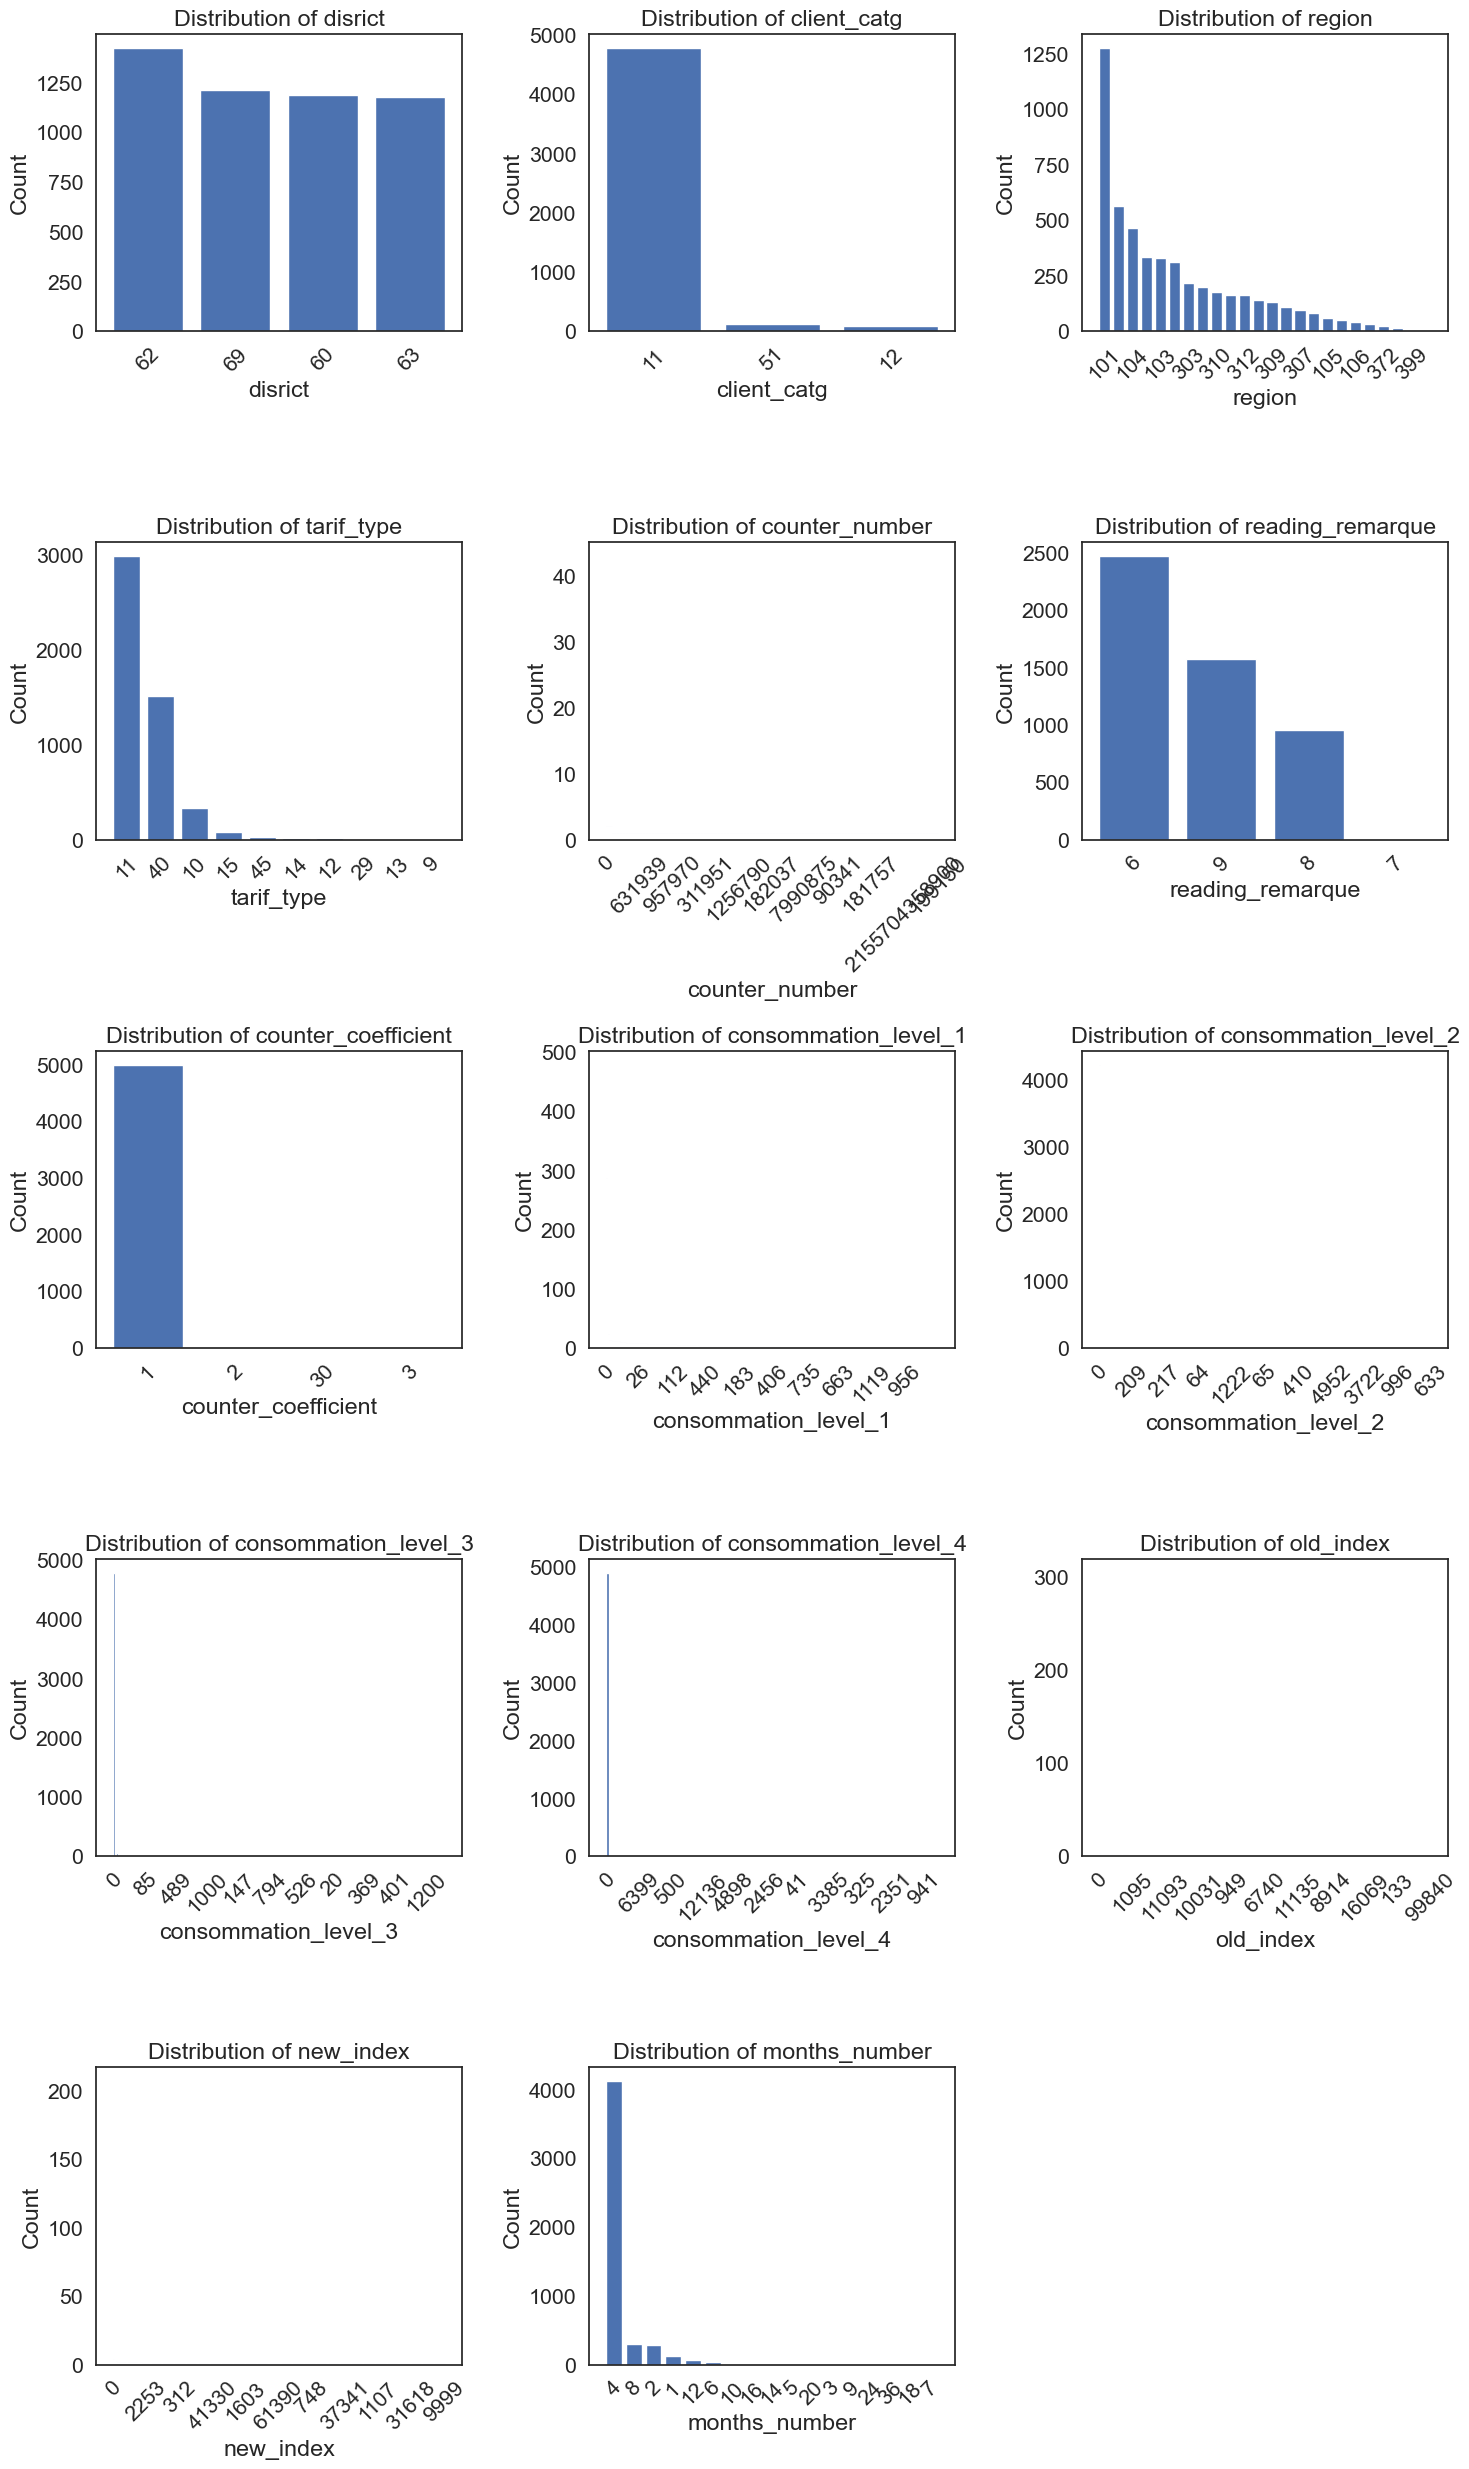

In [101]:
# check for imbalanced data

# Use the merged_train dataset and select relevant numerical columns
numeric_columns = [
    'disrict', 'client_catg', 'region', 
    'tarif_type', 'counter_number', 
    'reading_remarque', 'counter_coefficient', 
    'consommation_level_1', 'consommation_level_2',
    'consommation_level_3', 'consommation_level_4',
    'old_index', 'new_index', 'months_number'
]

# Set a smaller sample size for visualization to speed up the process
sample_size = 5000  # Reduced sample size
merged_sample = merged_train.sample(n=sample_size, random_state=42)

# Pre-calculate value counts for all numeric columns
value_counts = {col: merged_sample[col].value_counts() for col in numeric_columns}

# Set the number of rows and columns for subplots
num_vars = len(numeric_columns)
num_cols = 3  # Adjust this value based on how many columns you want in the grid
num_rows = (num_vars + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

# Iterate over each top correlated variable and plot
for i, feature in enumerate(numeric_columns):
    counts = value_counts[feature]
    axes[i].bar(counts.index.astype(str), counts.values)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
    # Rotate x-axis labels for better readability and display only some ticks
    axes[i].tick_params(axis='x', rotation=45)
    
    # Show fewer x-ticks: display every nth label depending on unique values
    if len(counts.index) > 10:  # Adjust the number of ticks based on the length
        step = len(counts.index) // 10  # Show only about 10 labels
        axes[i].set_xticks(counts.index[::step].astype(str))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

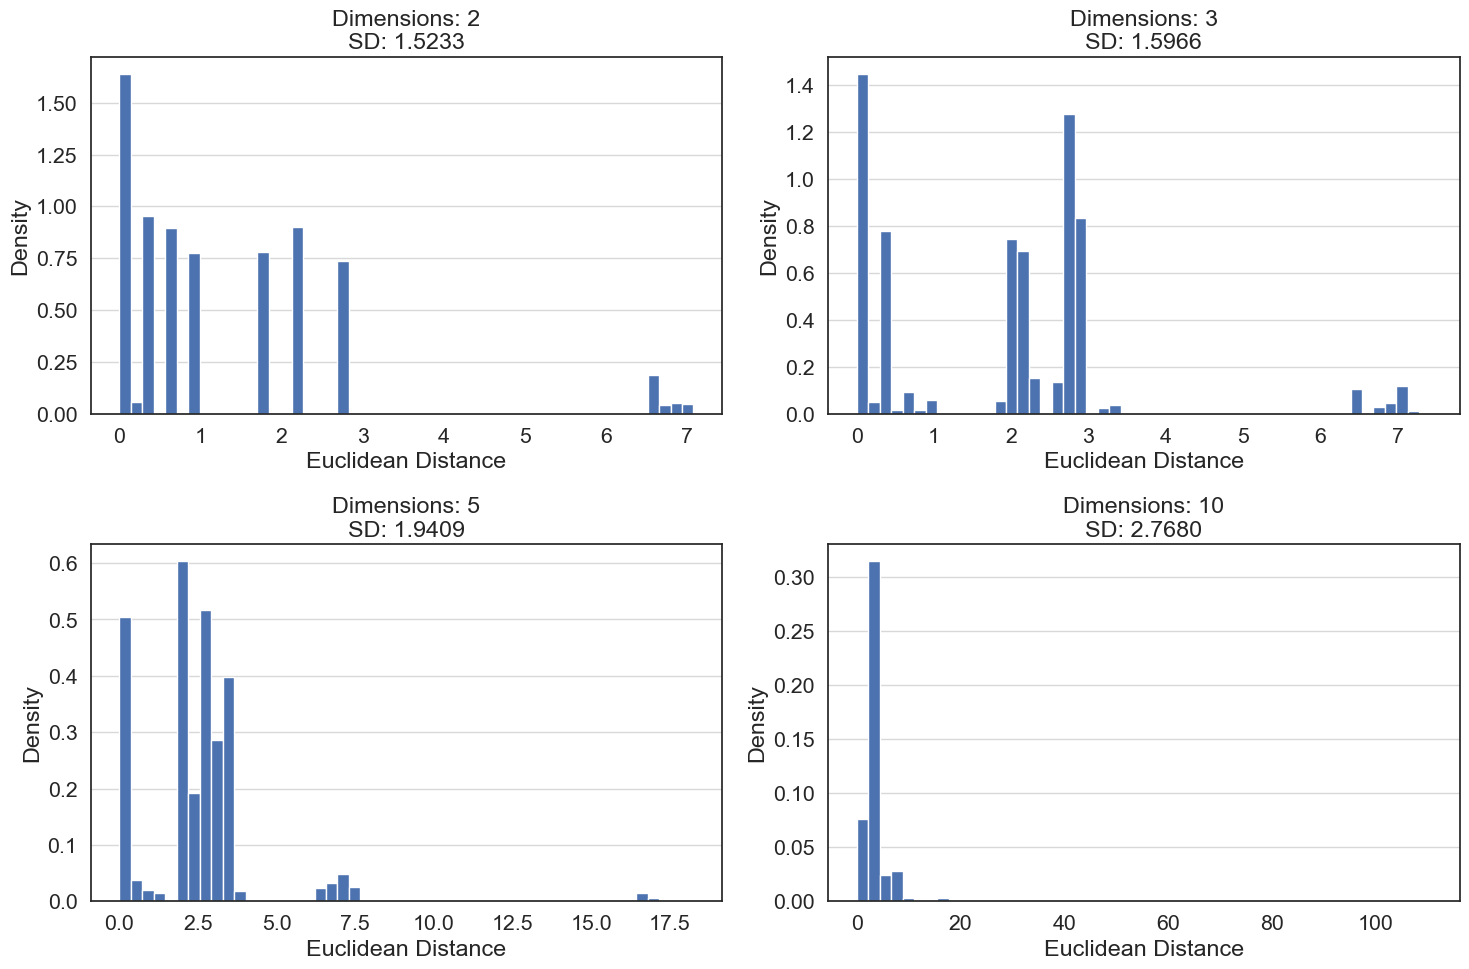

In [102]:
# check for curse of dimensionality
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

# Randomly sample a subset of the data (e.g., 10,000 samples)
sample_size = 10000 
merged_sample = merged_train.sample(n=sample_size, random_state=42)

# Standardize the data for better distance computation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_sample[numeric_columns])

# Function to plot histograms for given dimensions
def plot_histograms(data, dimensions, num_bins=50):
    plt.figure(figsize=(15, 10))
    
    for idx, dim in enumerate(dimensions):
        # Calculate Euclidean distances for the specified dimensions
        distances = pairwise_distances(data[:, :dim])
        distance_vector = distances[np.triu_indices(distances.shape[0], k=1)]
        
        # Calculate the standard deviation of distances
        sd = np.std(distance_vector)
        
        # Plot histogram
        plt.subplot(2, 2, idx + 1)
        plt.hist(distance_vector, bins=num_bins, density=True)
        plt.title(f'Dimensions: {dim}\nSD: {sd:.4f}')
        plt.xlabel('Euclidean Distance')
        plt.ylabel('Density')
        plt.grid(axis='y', alpha=0.75)

    plt.tight_layout()
    plt.show()

# Define dimensions to explore
dimensions_to_plot = [2, 3, 5, 10] 

# Plot histograms
plot_histograms(scaled_data, dimensions_to_plot)

Conclusion: <br>
The histogram of Euclidean distances shows that both standard deviation and variance increase as the number of dimensions grows. This suggests that the dataset has too many features, leading to sparsity, which makes it difficult to identify the true decision boundaries for classification. The high variance in the model, when fitting to sparse training data, increases the risk of overfitting.

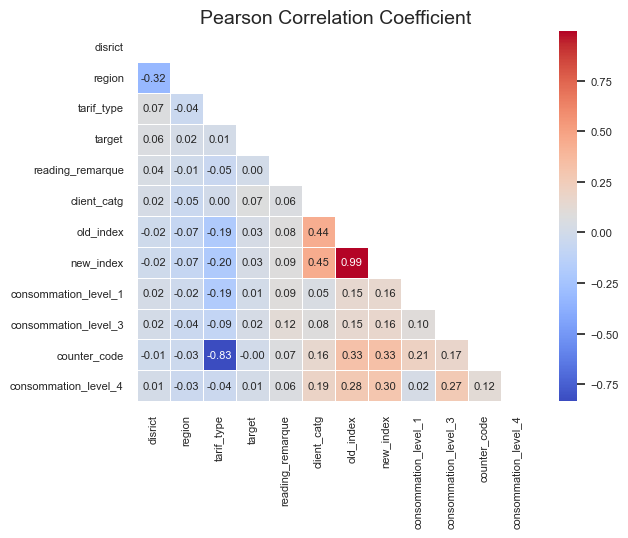

In [103]:
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str = 'Pearson Correlation Coefficient') -> None:
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include='number')

    # Calculate correlation between numeric variables
    corr = numeric_cols.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    heatmap = sns.heatmap(top_corr, mask=mask, annot=True , annot_kws={"size": 8}, 
                          cmap='coolwarm', fmt='.2f', 
                          linewidths=0.5, cbar=True, )
    plt.title(title_name, fontsize=14)
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8, rotation=0)

    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)

    plt.show()

# Plot heatmap of top 12 correlations in training data for numeric columns
plot_top_correlations(merged_train, 12, 'Pearson Correlation Coefficient')

Conclusion: <br>
The Pearson correlation coefficient measures the linear relationship between pairs of features, where values close to 1 indicate a strong positive correlation, values close to -1 indicate a strong negative correlation, and values around 0 indicate little or no linear relationship.

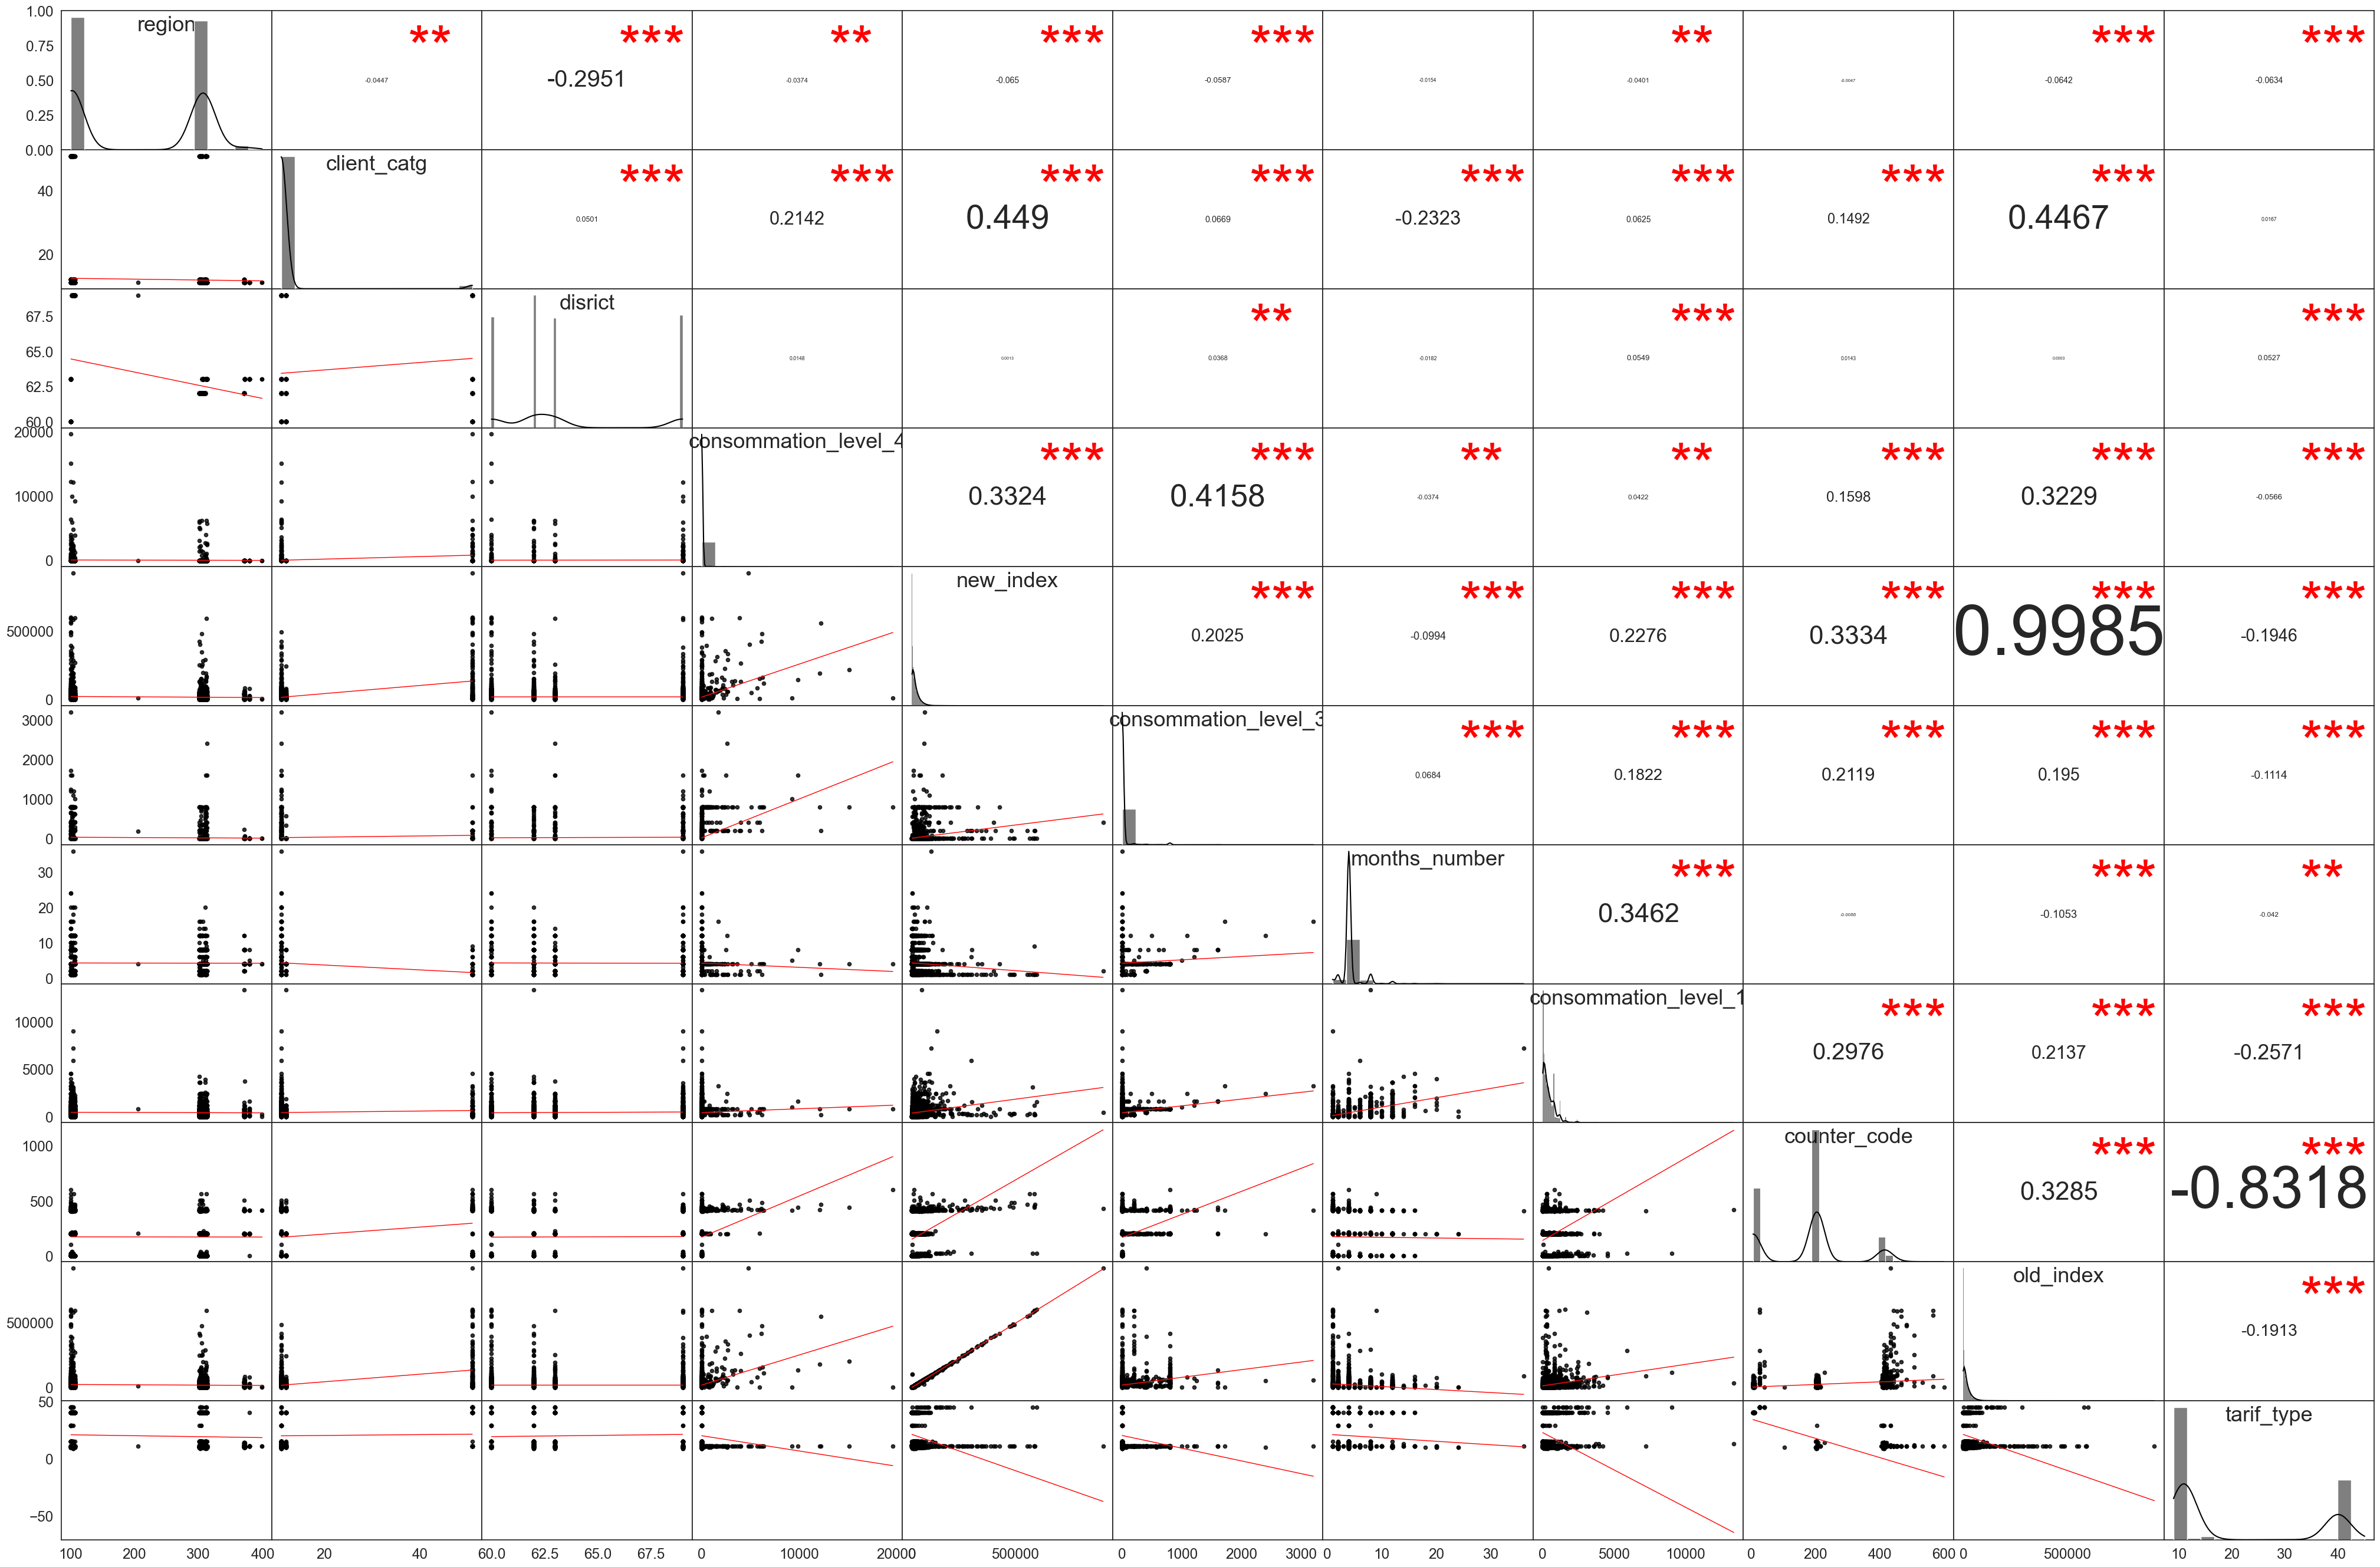

In [104]:
# mitigate curse of dimensionality
from scipy import stats

# Select a smaller sample size
sample_size = 5000  # Adjusted sample size
merged_sample = merged_train.sample(n=sample_size, random_state=42)

# Select only numeric columns
numeric_cols = merged_sample.select_dtypes(include='number')

# Calculate correlation between numeric variables
corr = numeric_cols.corr()

# Select variables having highest absolute correlation (top 6)
top_corr = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr_pairs = top_corr[top_corr < 1].head(12).index.tolist()

# Create a list of unique pairs for plotting
top_corr_cols = list(set([pair[0] for pair in top_corr_pairs] + [pair[1] for pair in top_corr_pairs]))

# Function definitions for correlation and plotting
def corrdot(x, y, **kwargs):
    corr_r = x.corr(y, 'pearson')
    corr_text = round(corr_r, 4)
    ax = plt.gca()
    font_size = abs(corr_r) * 80 + 5
    ax.annotate(corr_text, [0.5, 0.5], xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=70)

# Plotting
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(merged_sample[top_corr_cols], aspect=1.5, diag_sharey=False, despine=False)
g.map_lower(sns.regplot, ci=False,
            line_kws={'color': 'red', 'lw': 1},
            scatter_kws={'color': 'black', 's': 20})
g.map_diag(sns.histplot, color='black', kde=True)
g.map_upper(corrdot)
g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)

# Remove axis labels
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# Add titles to the diagonal axes/subplots
for ax, col in zip(np.diag(g.axes), top_corr_cols):
    ax.set_title(col, y=0.82, fontsize=26)

plt.show()


Conclusion: <br>
1. The corrrelation coefficients (numeric values on the upper half of the pairplot) represent the Pearson correlation coefficients between pairs of features. 
- Values near 1 indicate positive correlation meaning that as one variable increases, the other variable tends to increase.
- Values near -1 indicate negative correlation meaning that as one variable increases, the other variable tends to decrease.
- Values near 0 indicate weak or no linear relationship. 
<br>
2. Astericks show statistical significance of the correlations.
- `*` indicates p ≤ 0.05 (significant)
- `**` indicates p ≤ 0.01 (more significant)
- `***` indicates p ≤ 0.001 (highly significant)
<br>
3. Scatterplots and trendlines (lower half of the pairplot)
- The scatterplots show the relationships between pairs of features, with red trendlines indicating the direction of the relationships (positive or negative).
- A linear pattern would indicate a stronger relationship, while a dispersed or random pattern suggests weak or no relationship. <br>

The curse of dimensionality can lead to overfitting and increased computational complexity when working with many features. It’s important to reduce the number of features, especially those that add redundant or irrelevant information. Features that are highly correlated with each other may provide redundant information and can often be removed.

Features to consider reducing:
   - `old_index` and `new_index`: These have a very high correlation (close to 1, with a coefficient of 0.9959), meaning they essentially provide the same information. Including both in a machine learning model may be redundant, so you could drop one of them.
   - `client_catg` and `region`: They have a strong negative correlation (-0.8316), meaning they are inversely related. Depending on your model, you may want to choose one of them. <br>

Other highly correlated features:
   - `tariff_type` and `region` (0.4473) show moderate correlation.
   - `cbnsommation_level_3` and `cbnsommation_level_4` (0.3637) also show a strong positive correlation, indicating potential redundancy.

Weak correlations:
   - Some features, such as `district`, seem to have lower or no significant correlation with other features (as seen by smaller correlation values), suggesting they may not provide much predictive power and could potentially be ignored in feature selection.